In [584]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (12, 9)
save_images = True

In [585]:
def show(filename):
    if save_images:
        plt.show()
    else:
        plt.savefig(filename)

# Assignment 1

**IMPORTANT**: When finished all problems, rerun your entire notebook by clicking `Kernel > Restart Kernel and Run All Cells` to make sure your notebook runs correctly.

## 1. Sequential Labeling

In this problem, you will implement a system that labels objects in binary images and compute their geometric properties.

Let's first load our sample image and display it.

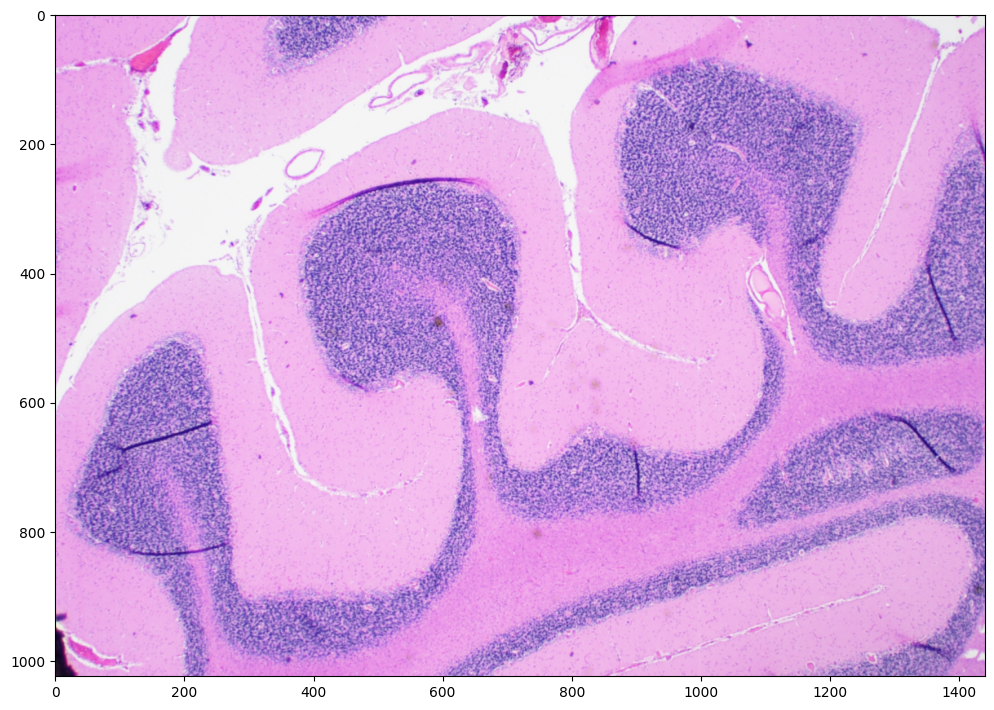

In [586]:
img = plt.imread('test_images/7.png')

plt.imshow(img, cmap='gray')
show('results/1_preview.png')

In [587]:
# what are the top colors and their frequencies? Group similar colors together in bins
def top_colors(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels = image.reshape(-1, 3) * 256

    # Define the number of bins per channel
    bins = 8  # You can adjust this number

    # Quantize the colors by reducing color depth
    quantized_pixels = (pixels // (256 // bins)) * (256 // bins)

    # Convert to integer type
    quantized_pixels = quantized_pixels.astype(np.uint8)

    # Get unique colors and their counts
    colors, counts = np.unique(quantized_pixels, axis=0, return_counts=True)
    # Sort by frequency
    sorted_indices = np.argsort(-counts)
    colors = colors[sorted_indices]
    counts = counts[sorted_indices]

    top_n = 5

    return colors[:top_n], counts[:top_n]


# smooth the image
smoothed_img = cv2.GaussianBlur(img, (5, 5), 0)
colors, count = top_colors(smoothed_img)


# create images for every color where the image is filtered by pixels to only show that color. Group similar colors together in bins and return a dictionary of colors to images

def color_images(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels = image.reshape(-1, 3) * 256

    # Define the number of bins per channel
    bins = 8  # You can adjust this number

    # Quantize the colors by reducing color depth
    quantized_pixels = (pixels // (256 // bins)) * (256 // bins)

    # Convert to integer type
    quantized_pixels = quantized_pixels.astype(np.uint8)

    # Get unique colors and their counts
    colors, counts = np.unique(quantized_pixels, axis=0, return_counts=True)
    # Sort by frequency
    sorted_indices = np.argsort(-counts)
    colors = colors[sorted_indices]
    counts = counts[sorted_indices]

    color_images = {}
    for color in colors[:5]:
        mask = np.all(quantized_pixels == color, axis=1).reshape(image.shape[:2])
        color_images[tuple(color)] = image * mask[:, :, None]

    return color_images


colored_images = color_images(img)
all_images = list(colored_images.values())


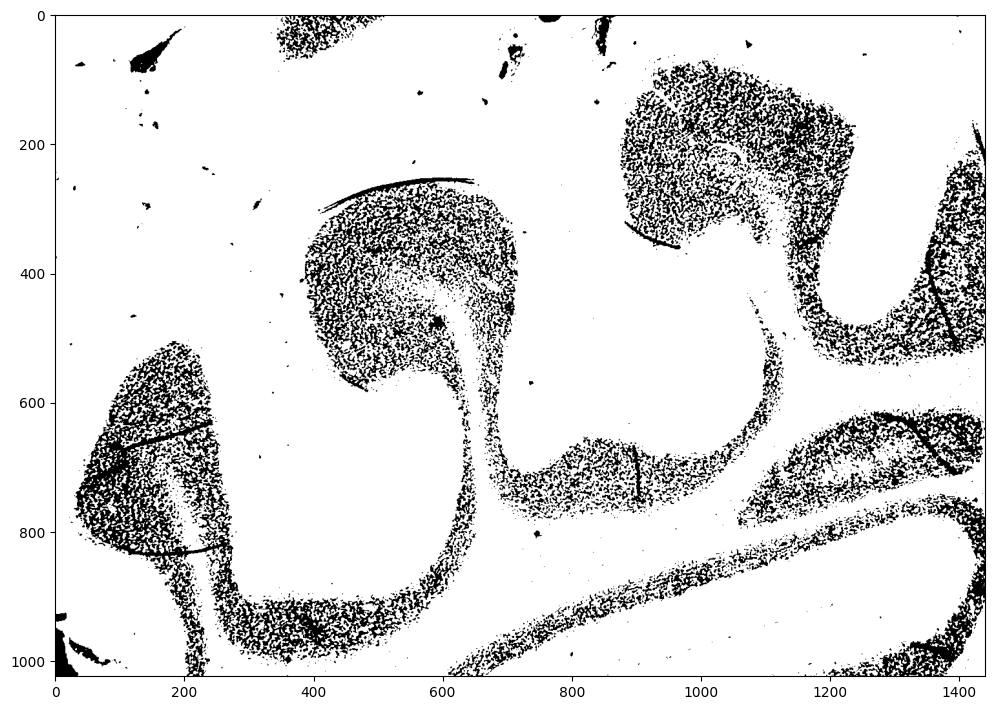

In [588]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
binary_img = (gray > 0.6).astype(np.float32)

plt.imshow(binary_img, cmap='gray')
show('results/1a.png')

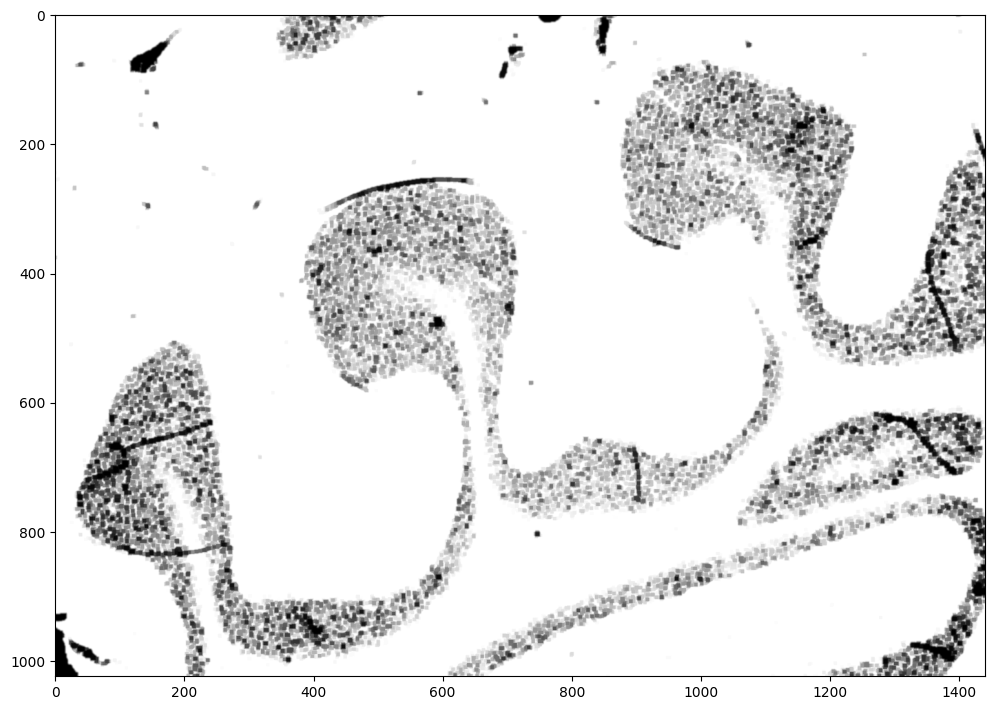

In [589]:
blurred = cv2.GaussianBlur(binary_img, (5, 5), 0)

kernel = np.ones((5, 5), np.uint8)

img_dilation = cv2.dilate(blurred, kernel, iterations=1)
img_erosion = cv2.erode(img_dilation, kernel, iterations=1)

noise_removed_img = img_erosion

plt.imshow(img_erosion, cmap='gray')
show('results/1b.png')

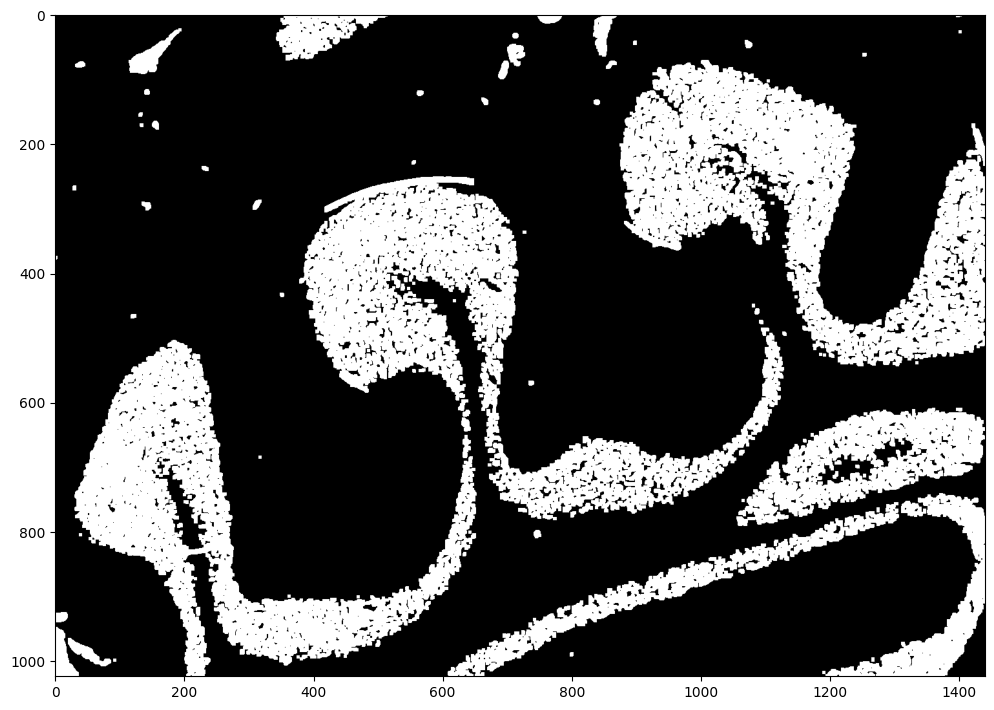

In [590]:
binary_img = (noise_removed_img < 0.95)

plt.imshow(binary_img, cmap='gray')
show('results/1c.png')


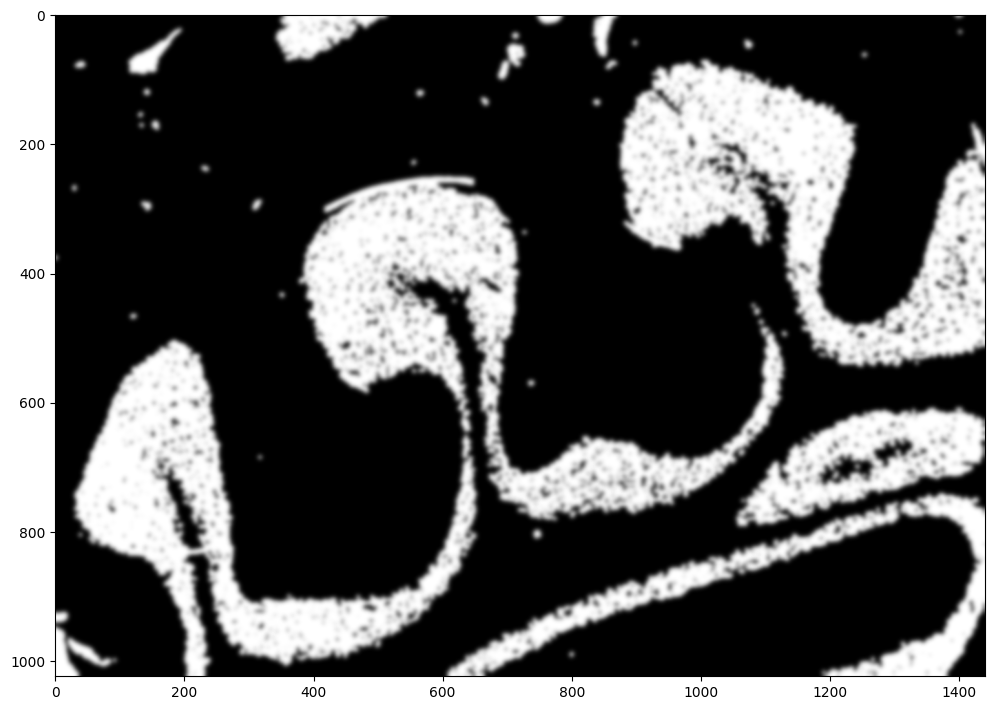

In [591]:
blurred = cv2.GaussianBlur((binary_img*255).astype(np.uint8), (21, 21), 0)
plt.imshow(blurred, cmap='gray')
show('results/1d.png')

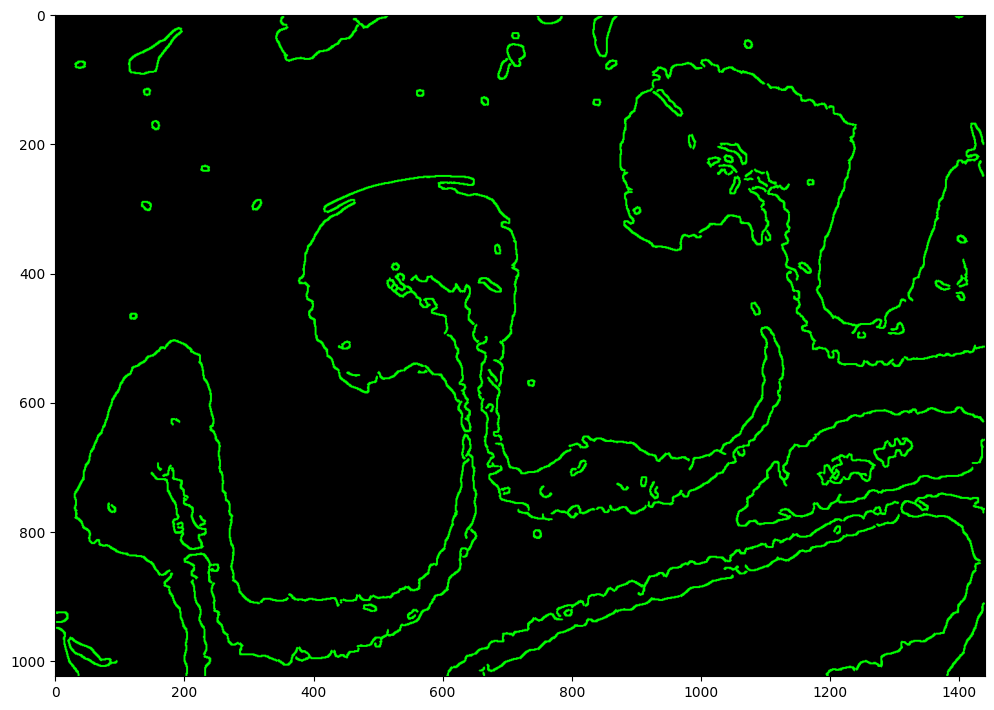

In [592]:
edges = cv2.Canny(blurred, 100, 200)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output_image = np.zeros_like(img)
cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)  # Draw contours in green
output_image = (output_image > 0).astype(np.float32)

plt.imshow(output_image)
show('results/3.png')


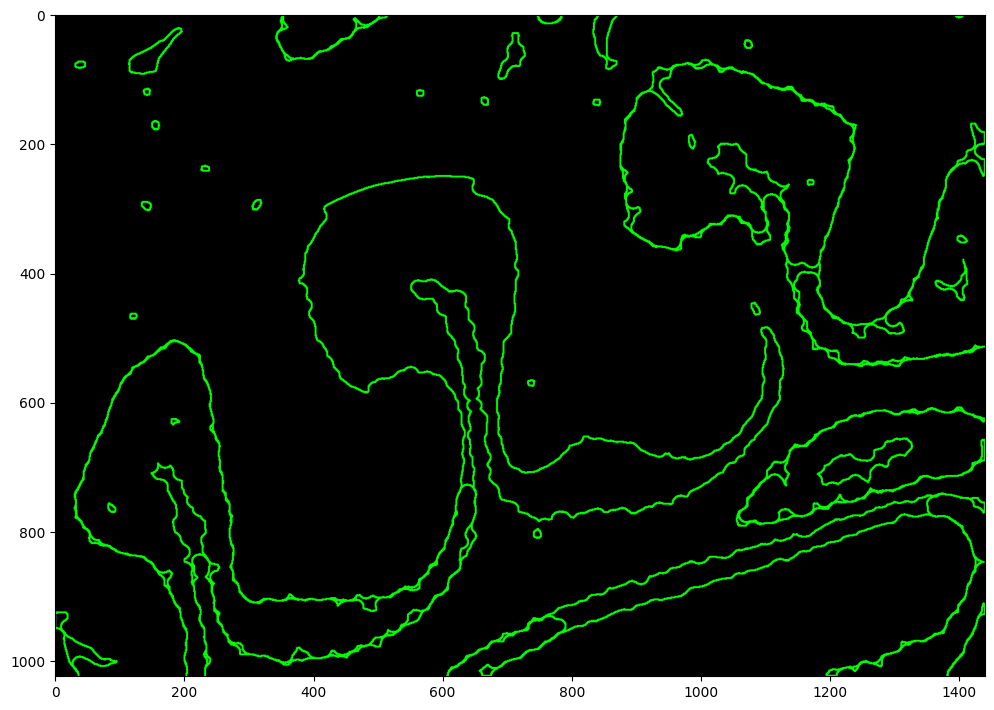

In [593]:
# Apply morphological closing to make edges curvier
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
curvy_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Find contours again on the curvy edges
contours, _ = cv2.findContours(curvy_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
curvy_output_image = np.zeros_like(img)
cv2.drawContours(curvy_output_image, contours, -1, (0, 255, 0), 2)  # Draw contours in green
curvy_output_image = (curvy_output_image > 0).astype(np.float32)

plt.imshow(curvy_output_image)
show('results/curvy_output_image.png')

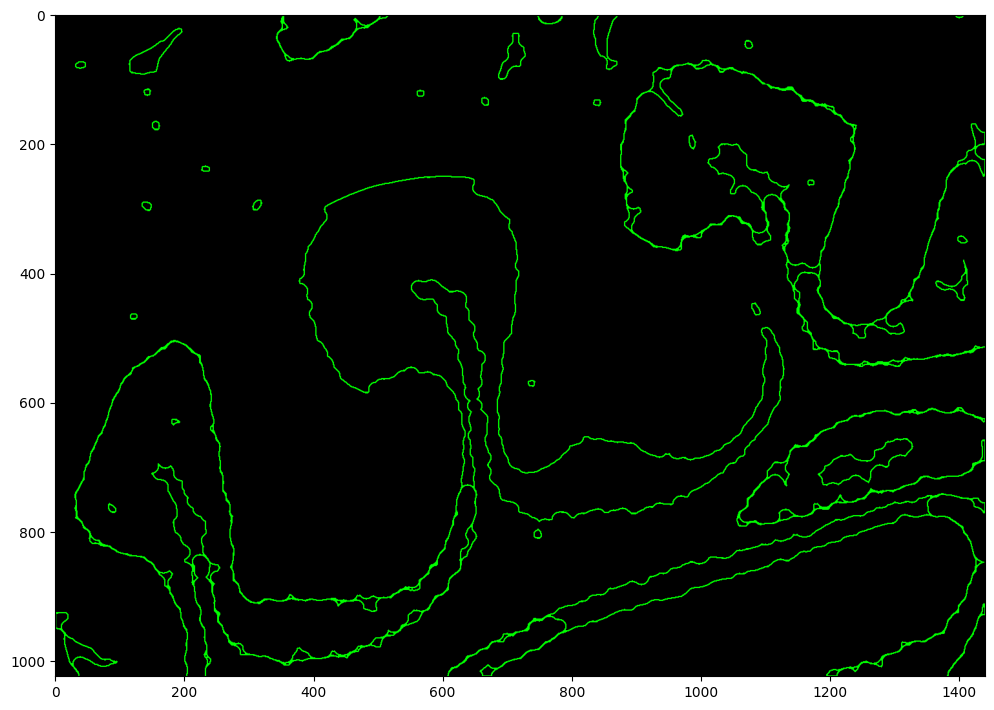

In [594]:
# Apply morphological erosion to thin the edges and remove overlaps
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
thinned_edges = cv2.erode(curvy_output_image, kernel, iterations=1)

plt.imshow(thinned_edges, cmap='gray')
show('results/thinned_edges.png')

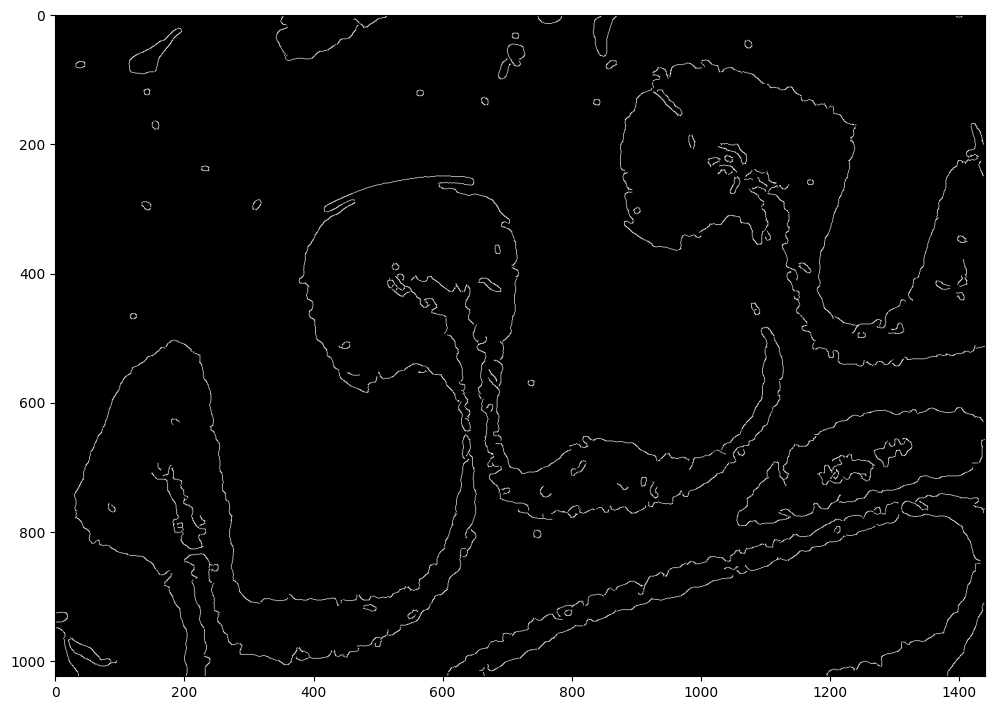

In [595]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
opened_edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)

plt.imshow(opened_edges, cmap='gray')
show('results/4.png')